In [197]:
#Unitary circuit of long range CNOT gate with and without dynamic decoupling, withouty DD is better
#because there exists no such error like idling error, therefore no need od DD

In [91]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def get_CNOT_circuit_static(num_qubit):
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)
    
    mid_qubit_index=int((num_qubit-1)/2)
    qc.h(0)
    for i in range(0,mid_qubit_index):
        qc.cx(i,i+1)
        qc.cx(i+1,i)
    
    for i in range(num_qubit-1-1,mid_qubit_index+1-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
        
    qc.cx(mid_qubit_index,mid_qubit_index+1)
    
    for i in range(mid_qubit_index-1,0-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
    qc.x(num_qubit-1)
    for i in range(mid_qubit_index+1,num_qubit-1):
        qc.cx(i,i+1)
        qc.cx(i+1,i)
   
    #for i in range(num_qubit):
        #qc.measure(qr[i],cr3[i])
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    return qc

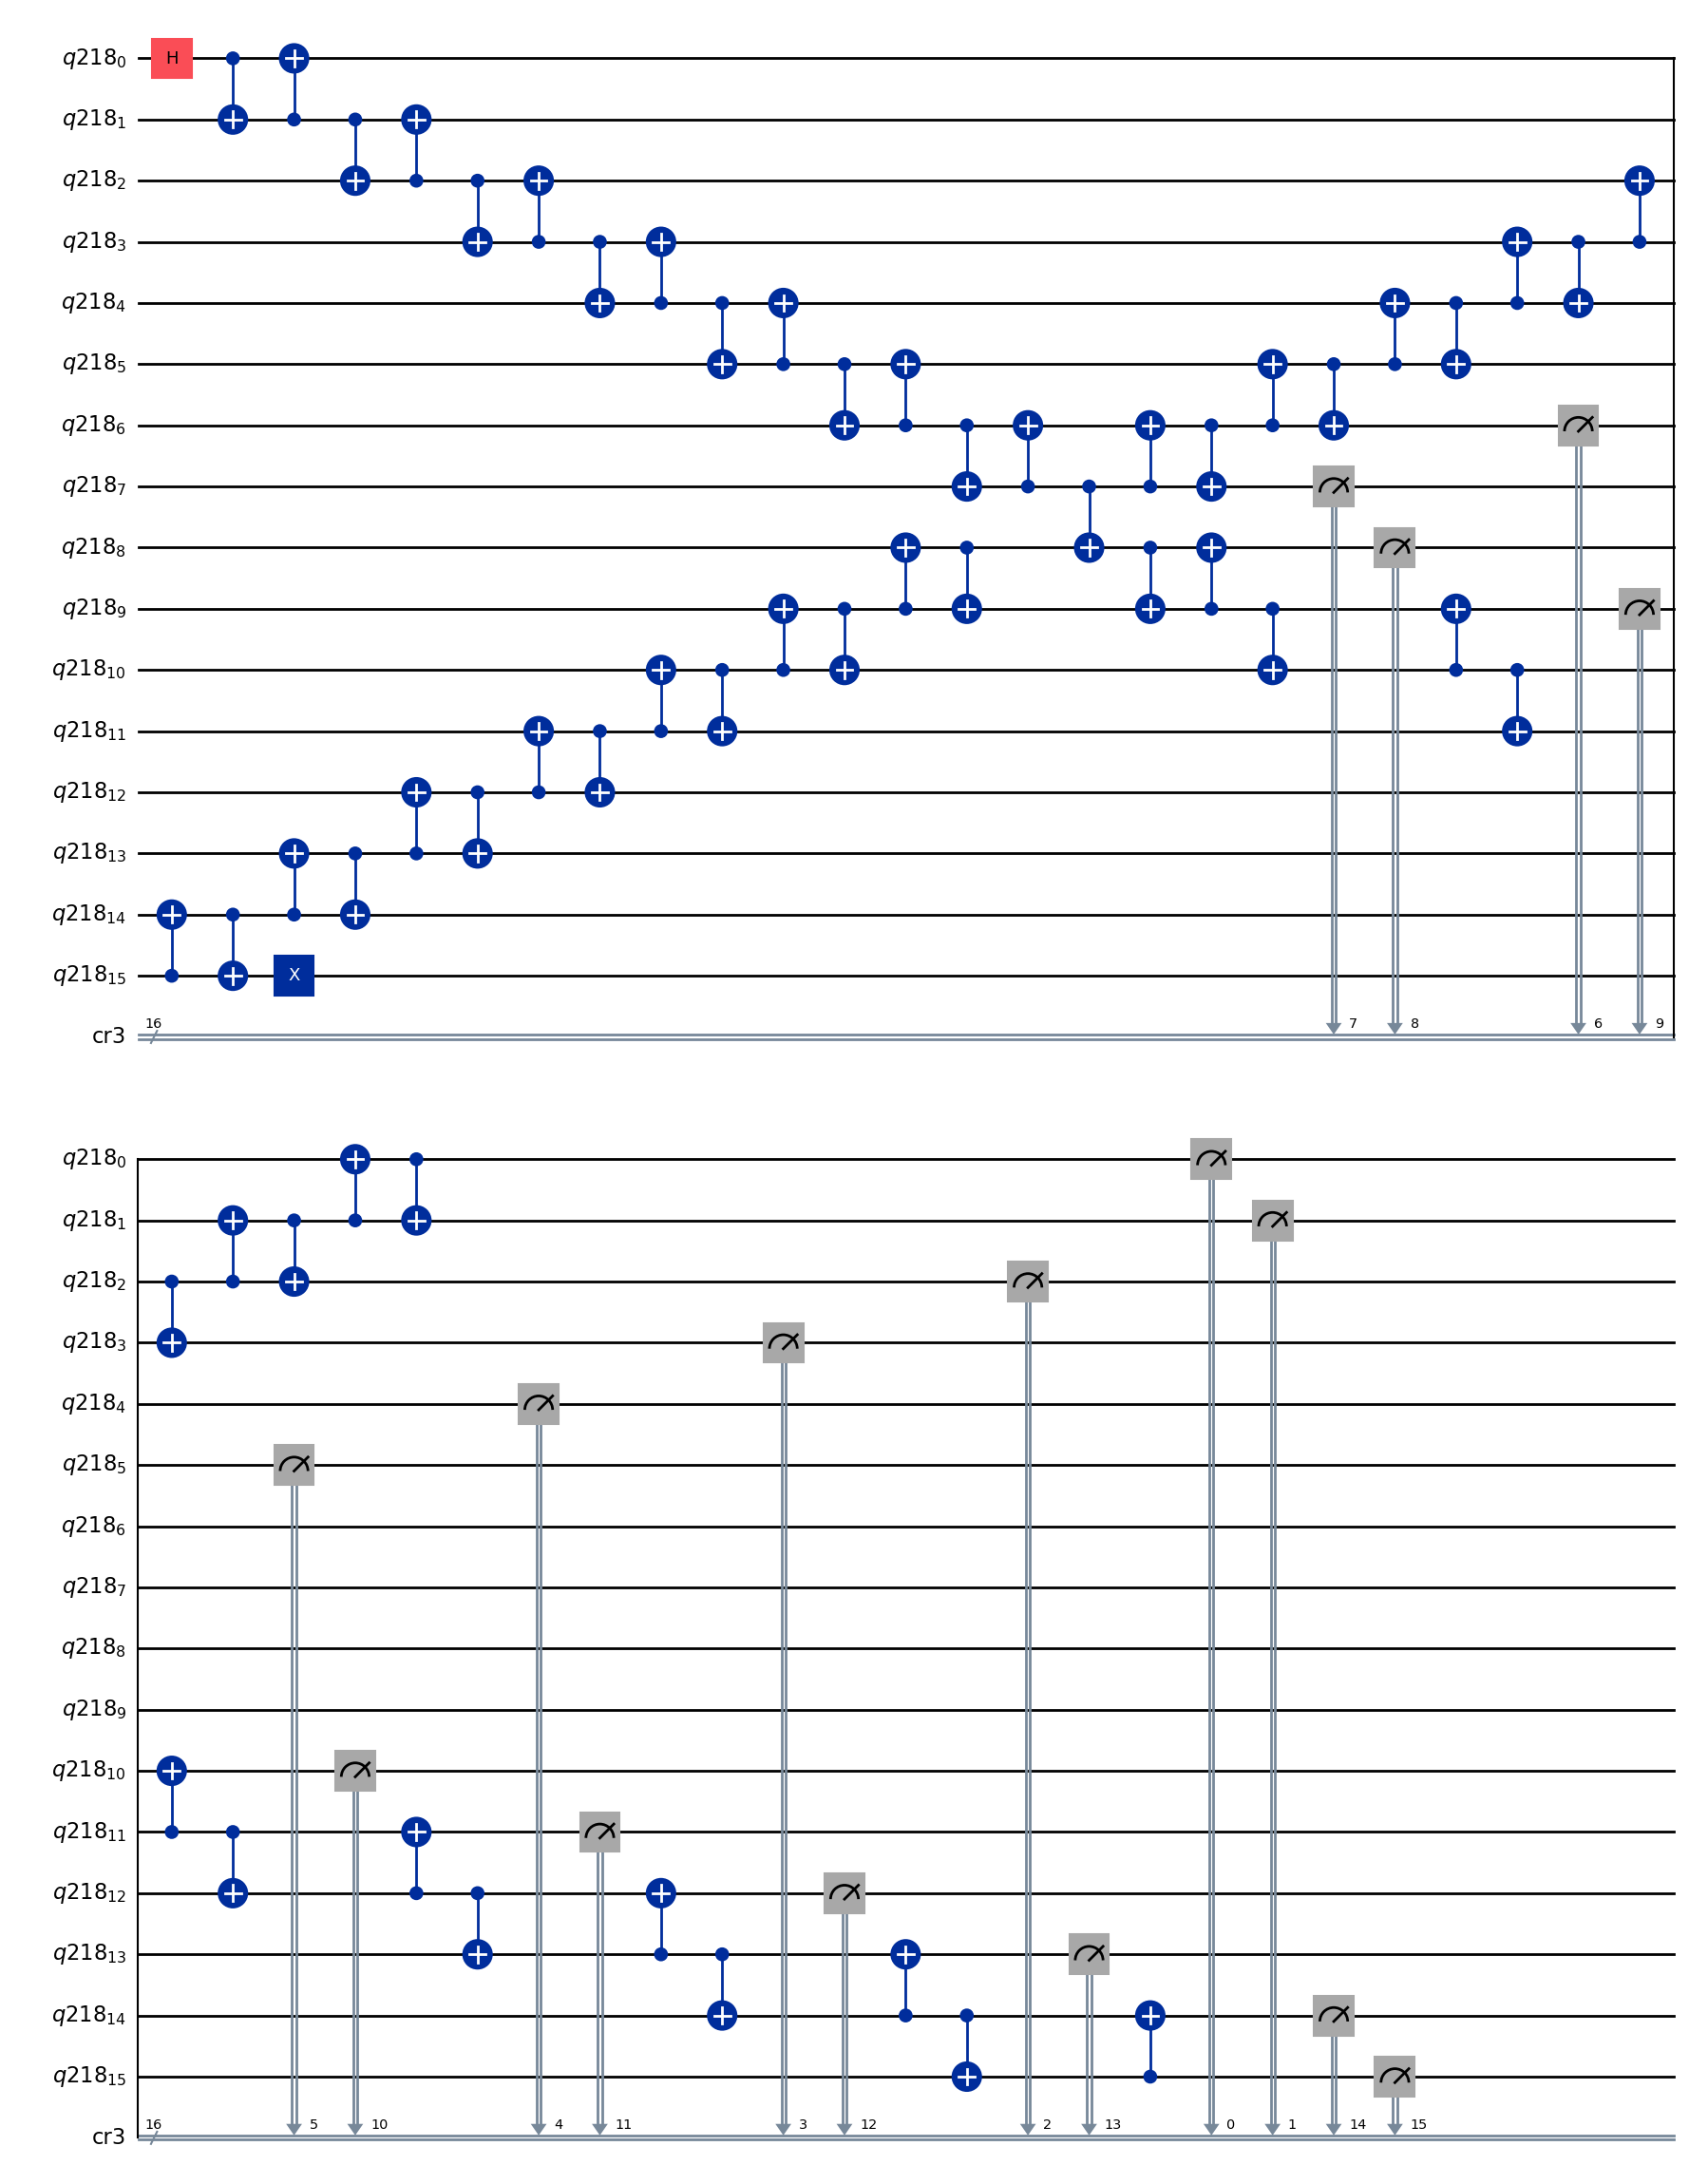

In [116]:
qc = get_CNOT_circuit_static(num_qubit=16)
qc.draw('mpl')

In [117]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
 
target = backend.target
basis_gates = list(target.operation_names)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(1, target=target, seed_transpiler=12345)
qc_t = pm.run(qc)
qc_t.draw("mpl", fold=-1, idle_wires=False)
print(basis_gates)

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'for_loop', 'if_else', 'switch_case', 'delay']


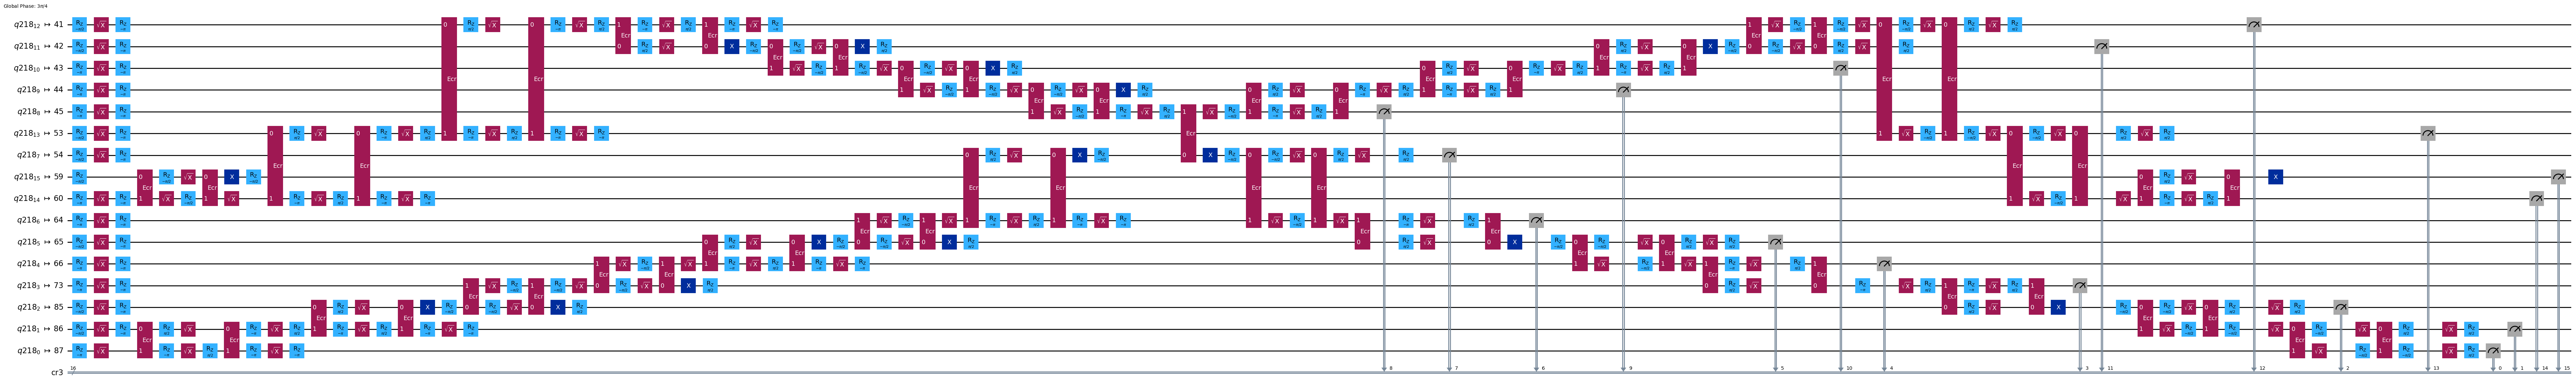

In [118]:
qc_t.draw("mpl", fold=-1, idle_wires=False)

In [119]:
from qiskit.circuit.library import XGate, YGate
 
X = XGate()
Y = YGate()
 
dd_sequence = [X, Y, X, Y]

In [120]:
from qiskit.transpiler import InstructionProperties
 
y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )
 
target.add_instruction(YGate(), y_gate_properties)

In [121]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
 
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)
qc_dd = dd_pm.run(qc_t)

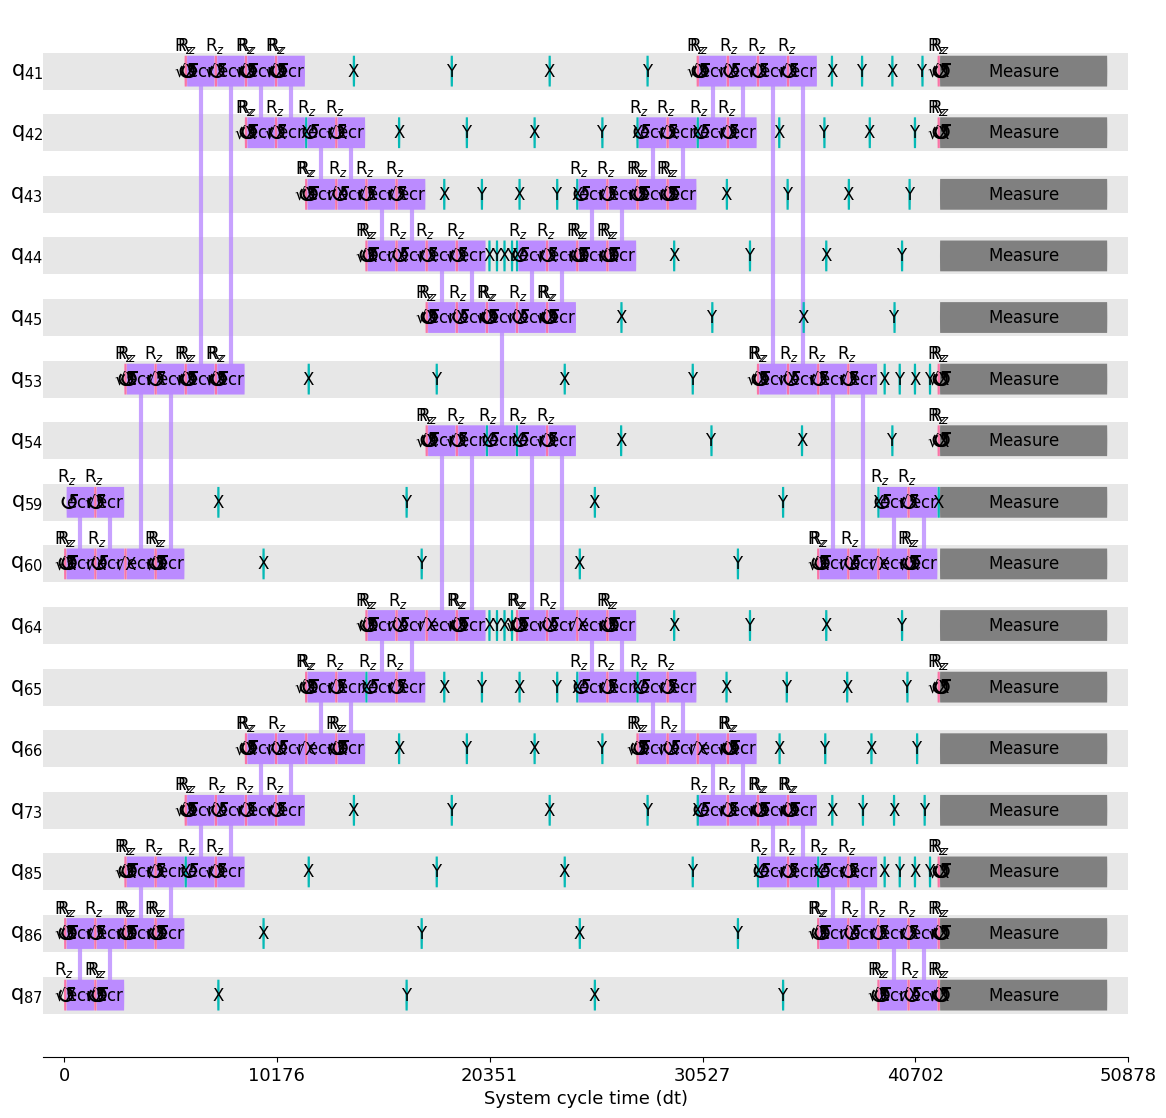

In [122]:
from qiskit.visualization import timeline_drawer
 
timeline_drawer(qc_dd, show_idle=False)

In [123]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()
aer = AerSimulator.from_backend(backend)
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qc_dd)
sampler = Sampler(backend=aer)
result = sampler.run([isa_qc]).result()

In [124]:
print(result)

PrimitiveResult([PubResult(data=DataBin<>(cr3=BitArray(<shape=(), num_shots=1024, num_bits=16>)))], metadata={})


In [125]:
counts1=result[0].data.cr3.get_counts()

In [126]:
print(counts1)

{'1100000000000000': 133, '1100000000001001': 8, '1110000010000001': 1, '0101000000001000': 2, '1000010000000010': 1, '0100000100000000': 13, '0100010000100001': 1, '0100010100100001': 1, '0100000000000001': 126, '0110000000000000': 12, '0100000101101001': 1, '1000100100000000': 1, '0100000000010011': 3, '1000000000001000': 3, '0101000000000001': 6, '1110000000100000': 1, '1000000000000001': 24, '1100000000000011': 10, '0100100000000000': 5, '0100000100010001': 3, '1101001000000000': 1, '1100000100100001': 1, '1100100010110000': 1, '0101000100011011': 1, '0110011000000000': 1, '1100000010000000': 9, '1100001000010000': 3, '1100000000010101': 1, '1100000000100000': 5, '1100000000000101': 13, '1100000000100001': 3, '1101000000010001': 2, '1110000100000001': 1, '1100000000010001': 21, '1100001000000000': 5, '0100000110000101': 1, '1110001000000001': 1, '0100000000010001': 9, '1100001000010001': 3, '1100000000000010': 7, '0100000000000101': 9, '1100000000011000': 3, '1100000000110001': 1, 

In [127]:
real_backend_2 = service.backend("ibm_brisbane")
aer_2 = AerSimulator.from_backend(real_backend_2)
 
# Run the sampler job locally using AerSimulator.
pm_2 = generate_preset_pass_manager(backend=aer_2, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(backend=aer_2)
result_2 = sampler.run([isa_qc]).result()
counts_2=result_2[0].data.cr3.get_counts()

In [128]:
aer_sim = AerSimulator()
pm_3 = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
qc_ideal_t=pm_3.run(qc)
sampler = Sampler(backend=aer_sim)
result_3 = sampler.run([qc_ideal_t]).result()
counts_3=result_3[0].data.cr3.get_counts()


In [129]:
from qiskit.quantum_info.analysis import hellinger_fidelity
Fidelity_dd=hellinger_fidelity(counts_3, counts1)
Fidelity_without_dd=hellinger_fidelity(counts_3, counts_2)

In [130]:
print(Fidelity_dd,Fidelity_without_dd)

0.25291359799665414 0.508647307698143


In [131]:
print(counts_3)

{'0100000000000001': 490, '1100000000000000': 534}
